<a href="https://colab.research.google.com/github/ramprakashyadav/invoice/blob/main/Invoice_detection2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip3 install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)

Found GPU at: /device:GPU:0
1.15.2


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd '/content/gdrive/My Drive/tensorflow/'

/content/gdrive/My Drive/tensorflow


In [5]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-tk is already the newest version (2.7.17-1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python-bs4 python-chardet python-html5lib python-olefile
  python-pkg-resources python-six python-webencodings
Suggested packages:
  python-genshi python-lxml-dbg python-lxml-doc python-pil-doc python-pil-dbg
  python-setuptools
The following NEW packages will be installed:
  python-bs4 python-chardet python-html5lib python-lxml python-olefile
  python-pil python-pkg-resources python-six python-webencodings
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,615 kB of archives.
After this operation, 8,916 kB of additional disk space will be used.
Get:1 htt

In [6]:
%cd /content/gdrive/My Drive/tensorflow/models/research/
!protoc object_detection/protos/*.proto --python_out=.

/content/gdrive/My Drive/tensorflow/models/research


In [7]:
import os
os.environ['PYTHONPATH'] += ':/content/gdrive/My Drive/tensorflow/models/research/:/content/gdrive/My Drive/tensorflow/models/research/slim'

In [8]:
!python setup.py build
!python setup.py install

running build
running build_py
copying object_detection/protos/anchor_generator_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/bipartite_matcher_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/argmax_matcher_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/box_coder_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/box_predictor_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/calibration_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/faster_rcnn_box_coder_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/center_net_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/eval_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/flexible_grid_anchor_generator_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/fpn_pb2.py -> build/li

In [9]:
import time, psutil
Start = time.time()- psutil.boot_time()
Left= 12*3600 - Start
print('Time remaining for this session is: ', Left/3600)

Time remaining for this session is:  11.781643514169588


In [10]:
%cd /content/gdrive/My Drive/tensorflow/models/research/object_detection/builders/
!python model_builder_test.py

/content/gdrive/My Drive/tensorflow/models/research/object_detection/builders
Using TensorFlow backend.


In [11]:
%cd /content/gdrive/My Drive/tensorflow/models/research/object_detection

/content/gdrive/My Drive/tensorflow/models/research/object_detection


In [ ]:
!python generate_tfrecord.py --csv_input=images/train_labels.csv --image_dir=images/train --output_path=train.record

In [ ]:
!python generate_tfrecord.py --csv_input=images/test_labels.csv --image_dir=images/test --output_path=test.record

In [ ]:
%load_ext tensorboard
%tensorboard --logdir training/

In [ ]:
!pip install numpy==1.16.1


In [ ]:
numpy.version.version

In [ ]:
!python train.py --logtostderr --train_dir=training/ --pipeline_config_path=training/faster_rcnn_inception_v2_pets.config

In [ ]:
!python export_inference_graph.py --input_type image_tensor --pipeline_config_path training/faster_rcnn_inception_v2_pets.config --trained_checkpoint_prefix training/model.ckpt-200000 --output_directory inference_graph

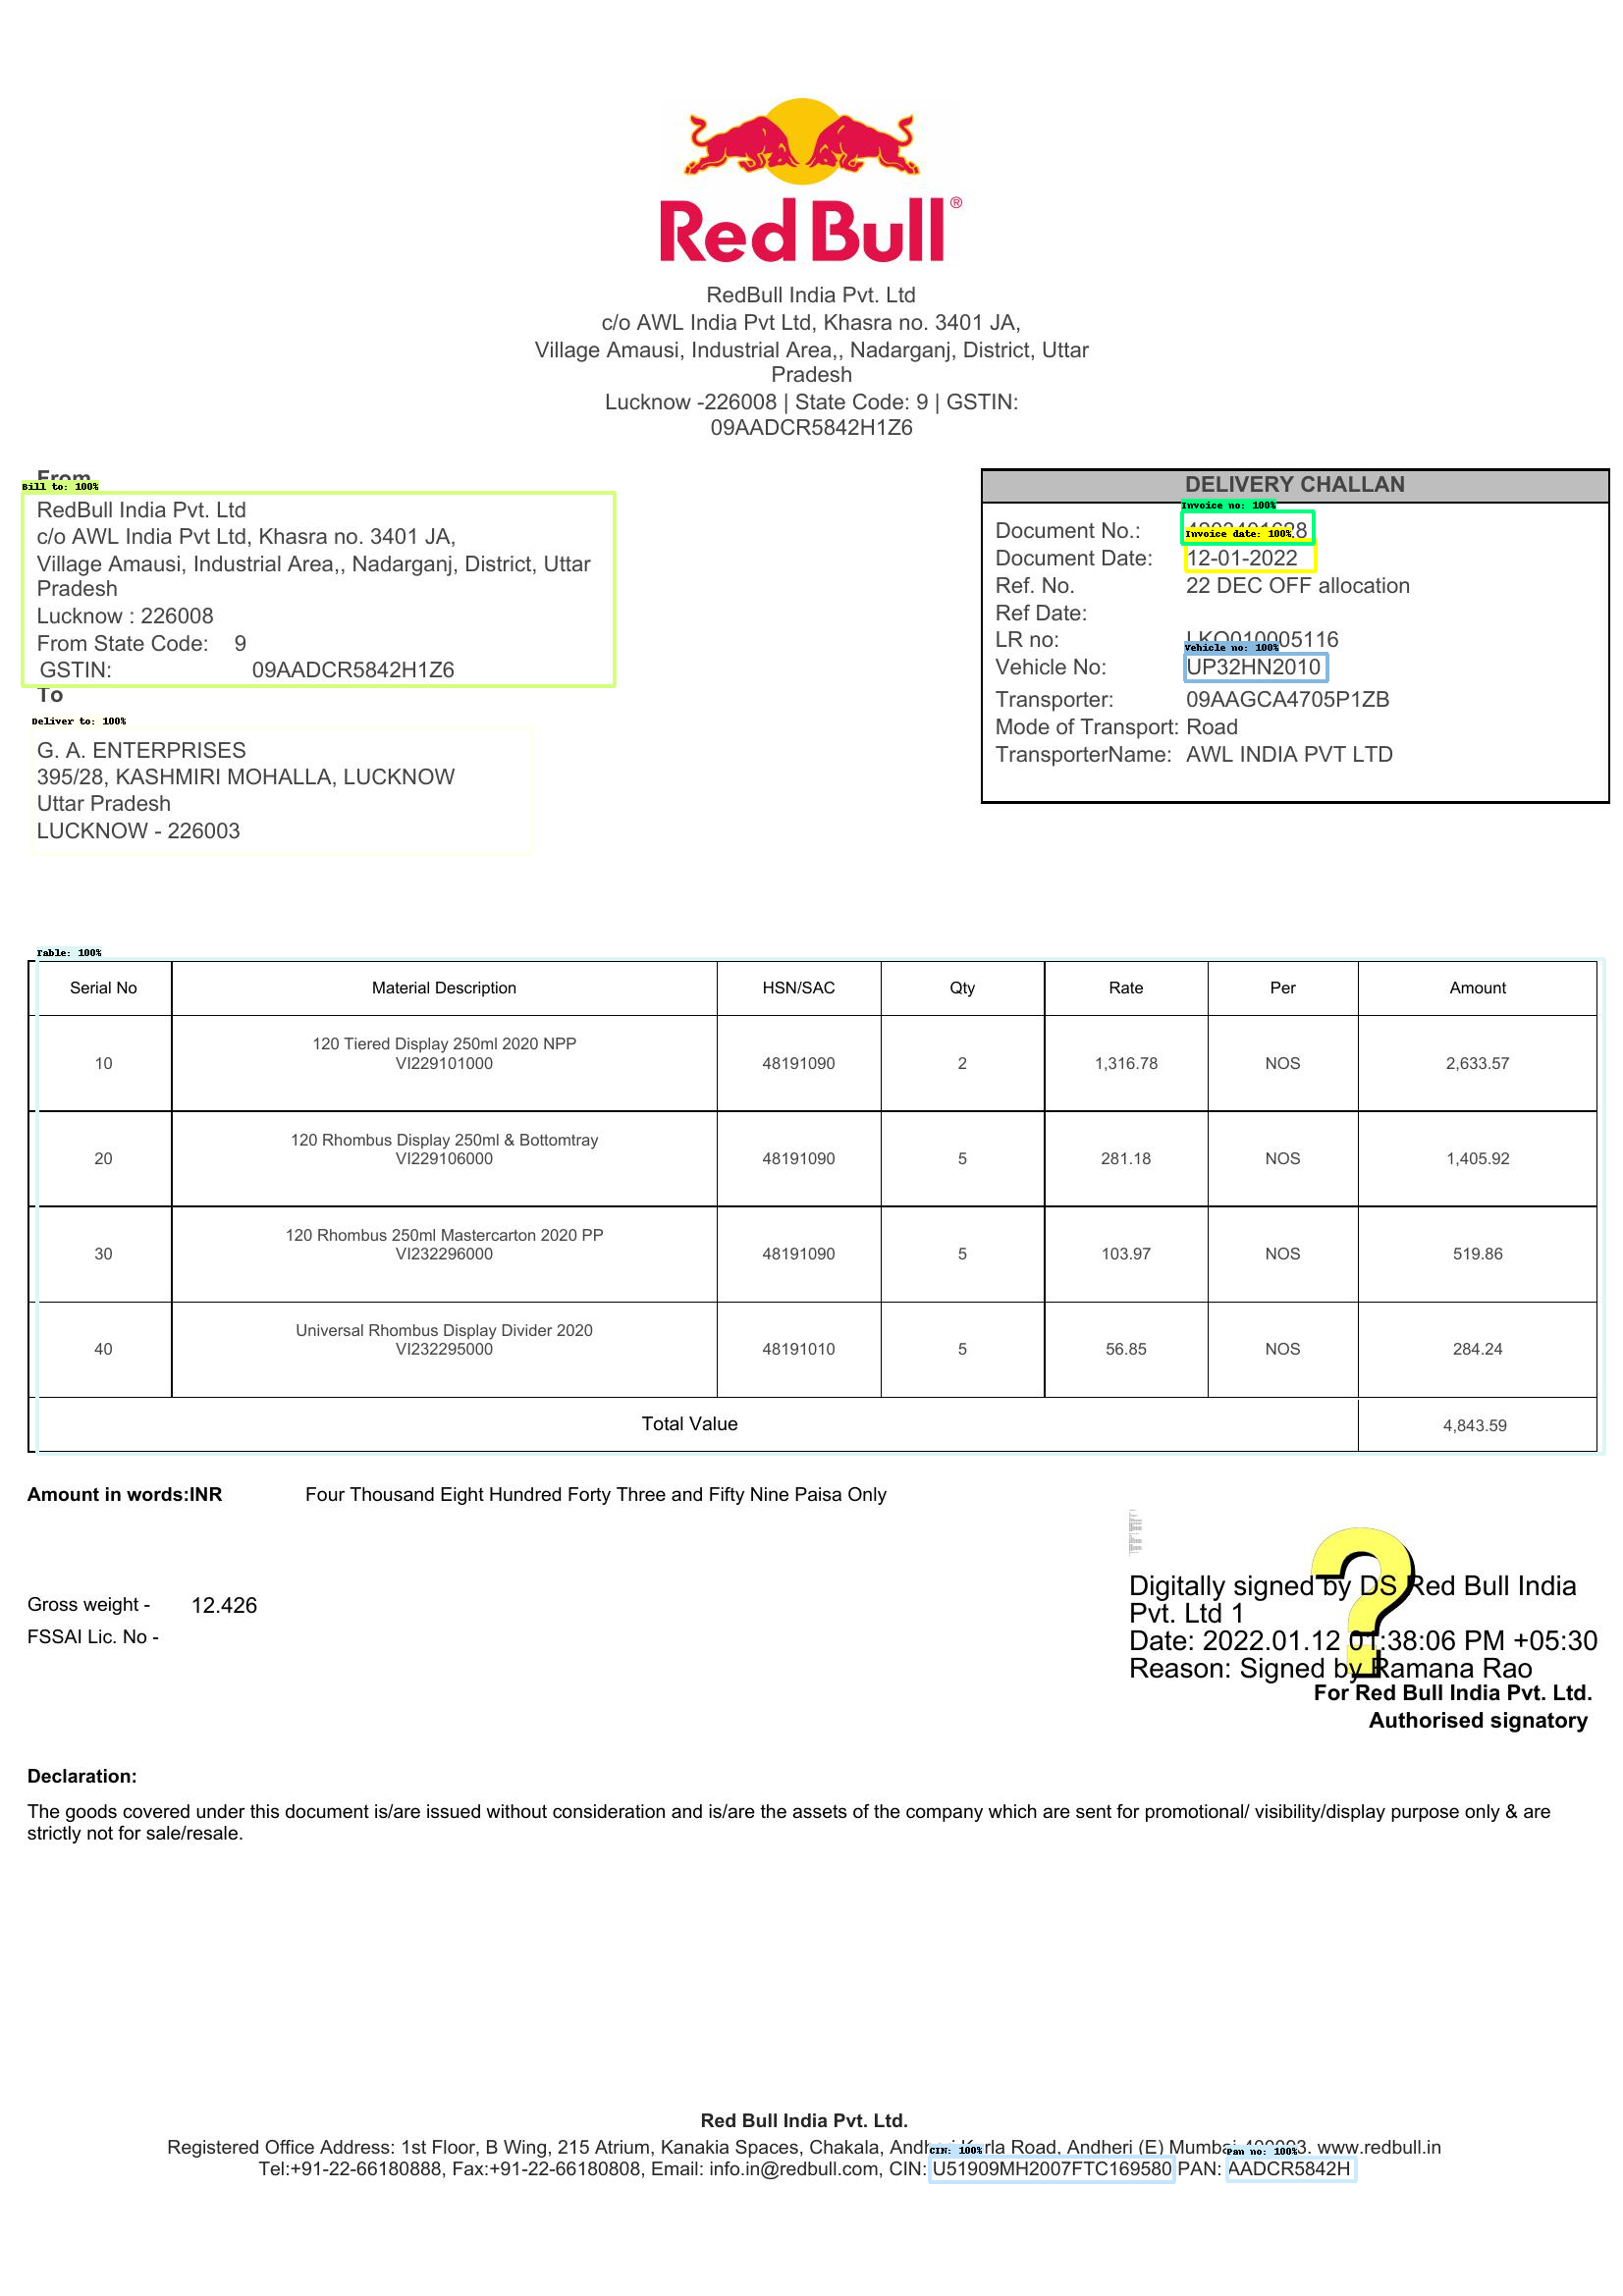

In [12]:
import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
import sys

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

# Import utilites
from utils import label_map_util
from utils import visualization_utils as vis_util

# Name of the directory containing the object detection module we're using
MODEL_NAME = 'inference_graph'
IMAGE_NAME = 'test6.jpg'

# Grab path to current working directory
CWD_PATH = os.getcwd()

# Path to frozen detection graph .pb file, which contains the model that is used
# for object detection.
PATH_TO_CKPT = os.path.join(CWD_PATH,MODEL_NAME,'frozen_inference_graph.pb')

# Path to label map file
PATH_TO_LABELS = os.path.join(CWD_PATH,'training','labelmap.pbtxt')

# Path to image
PATH_TO_IMAGE = os.path.join(CWD_PATH,IMAGE_NAME)

# Number of classes the object detector can identify
NUM_CLASSES = 12

# Load the label map.
# Label maps map indices to category names, so that when our convolution
# network predicts `5`, we know that this corresponds to `king`.
# Here we use internal utility functions, but anything that returns a
# dictionary mapping integers to appropriate string labels would be fine
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Load the Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.Session(graph=detection_graph)

# Define input and output tensors (i.e. data) for the object detection classifier

# Input tensor is the image
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Output tensors are the detection boxes, scores, and classes
# Each box represents a part of the image where a particular object was detected
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represents level of confidence for each of the objects.
# The score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

# Number of objects detected
num_detections = detection_graph.get_tensor_by_name('num_detections:0')

# Load image using OpenCV and
# expand image dimensions to have shape: [1, None, None, 3]
# i.e. a single-column array, where each item in the column has the pixel RGB value
image = cv2.imread(PATH_TO_IMAGE)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_expanded = np.expand_dims(image_rgb, axis=0)

# Perform the actual detection by running the model with the image as input
(boxes, scores, classes, num) = sess.run(
    [detection_boxes, detection_scores, detection_classes, num_detections],
    feed_dict={image_tensor: image_expanded})

# Draw the results of the detection (aka 'visulaize the results')

vis_util.visualize_boxes_and_labels_on_image_array(
    image,
    np.squeeze(boxes),
    np.squeeze(classes).astype(np.int32),
    np.squeeze(scores),
    category_index,
    use_normalized_coordinates=True,
    line_thickness=4,
    min_score_thresh=0.60)

# All the results have been drawn on image. Now display the image.
cv2_imshow(image)

# Press any key to close the image
cv2.waitKey(0)

# Clean up
cv2.destroyAllWindows()

In [ ]:
INPUT_FOLDER = "/content/gdrive/MyDrive/tensorflow/models/research/object_detection/input_images/"
CROPPED_FOLDER ="/content/gdrive/MyDrive/tensorflow/models/research/object_detection/cropped_images/"
OUTPUT_TEXT ="/content/gdrive/MyDrive/tensorflow/models/research/object_detection/output_text/"
OUTPUT_CSV="/content/gdrive/MyDrive/tensorflow/models/research/object_detection/output_csv/"

In [ ]:
!apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (31.4 MB/s)
Selecting previously unselecte

In [ ]:
import pytesseract
import pandas as pd

out_all = []
for fl in os.listdir(INPUT_FOLDER):
  print(fl)
  in_all = {}
  in_all['file'] = fl
  image = cv2.imread(INPUT_FOLDER + fl)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_expanded = np.expand_dims(image_rgb, axis=0)
  (boxes, scores, classes, num) = sess.run(
    [detection_boxes, detection_scores, detection_classes, num_detections],
    feed_dict={image_tensor: image_expanded})
  
  height=image.shape[0]
  breath=image.shape[1]
  print(breath,height)
  i = 0 
  for box,class_,score in zip(boxes[0],classes[0],scores[0]): 
    if score>0.6: 
      #print(box,class_,score) 
      # print(box[0]*height,box[1]*breath,box[2]*height,box[3]*breath) 
      crop_image = image[int(box[0]*height):int(box[2]*height),int(box[1]*breath):int(box[3]*breath)] 
      cv2.imwrite(CROPPED_FOLDER + fl.replace(".jpg","") +"_"+str(i)+".jpg",crop_image)

      extracted_text=pytesseract.image_to_string(crop_image)
      in_all[str(int(class_))] = extracted_text 
      # print(extracted_text)
      with open(OUTPUT_TEXT + fl.replace(".jpg","") +"_"+str(i)+".txt",'w') as txt_file:
                txt_file.write(extracted_text)
      i = i+1
  out_all.append(in_all)
  mapping = {'1': 'Invoice no','2':'Invoice date','3':'Bill to','4':'Deliver to','5':'Table','6':'CIN','7':'Pan no','8':'Total value','9':'Vehicle no','10':'SO number','11':'BAP ref number','12':'Our gstin no'}
  out_df = pd.DataFrame(out_all).rename(columns=mapping)
  out_df.to_csv(OUTPUT_CSV+'All_invoice.csv')


page__46_1ExtractPage7.pdf.jpg
1700 2200
page__41_1ExtractPage6.pdf.jpg
1700 2200
page__3_DELIVERY CHALLAN CN7362.pdf.jpg
1700 2200
page__3_HR0620000139_Integra_Mumbai.pdf.jpg
1653 2339
page__2_HR0620000126_Integra_Delhi.pdf.jpg
1653 2339
page__2_DELIVERY CHALLAN CN7359.pdf.jpg
1700 2200
page-1dfg567.jpg
1190 1684
page-1az.jpg
1190 1684
page-1df78.jpg
1190 1683
page-1dffhf.jpg
1190 1683
page__3_AR Invoice_21220194_20211201_084707.pdf.jpg
1653 2337
page__2_21220196 SEIPL FOC 02122021.pdf.jpg
1653 2337
page-1drgt6.jpg
1224 1584
page-1dg567.jpg
1224 1584
page-1frgt6.jpg
1190 1682
page-1ghty.jpg
1190 1682
page-1by56gd.jpg
1190 1684
page-1bghty68.jpg
1190 1684
page-1f678.jpg
1224 1584
page-1ct6.jpg
1224 1584
page-1ght6790.jpg
1190 1683
page-2ty67.jpg
1190 1683
page-1e5f.jpg
1190 1683
page-1d6.jpg
1224 1584
5477.jpg
1190 1683
8585.jpg
1190 1683
page-1hk.jpg
1190 1683
page-1k98.jpg
1190 1683
page__2_G.A.ENTERPRISES_4203401628.pdf.jpg
1653 2339
page__4_GOYALTRADERS_4203401670.pdf.jpg
1653 2339

In [ ]:
mapping = {'1': 'Invoice no','2':'Invoice date','3':'Bill to','4':'Deliver to','5':'Table','6':'CIN','7':'Pan no','8':'Total value','9':'Vehicle no','10':'SO number','11':'BAP ref number','12':'Our gstin no'}


In [ ]:
if row_label == 'Invoice no': 1
        return 1
    elif row_label == 'Invoice date':
        return 2
    elif row_label == 'Bill to':
        return 3
    elif row_label == 'Deliver to':
        return 4
    elif row_label == 'Table':
        return 5
    elif row_label == 'CIN':
        return 6
    elif row_label == 'Pan no':
        return 7
    elif row_label == 'Total value':
        return 8
    elif row_label == 'Vehicle no':
        return 9
    elif row_label == 'SO number':
        return 10
    elif row_label == 'BAP ref number':
        return 11
    elif row_label == 'Our gstin no':
        return 12

In [ ]:
# import glob
# import natsort
# import pandas as pd
# import os

In [ ]:
# dirpath = os.listdir(OUTPUT_TEXT)
# output = os.listdir(OUTPUT_CSV)
# csvout_lst = []
# files = [os.path.join(dirpath, fname) for fname in os.listdir(dirpath)]

# for filename in sorted(files):
#     data = pd.read_csv(filename, sep=':', index_col=0, header=None)
#     csvout_lst.append(data)

# pd.concat(csvout_lst).to_csv(output)